# Objetivo

<span style="color: black; font-family: Arial; font-size: 20px;">
O objetivo desta análise é entender os padrões de comportamento e frequência dos clientes da rede de academias Model Fitness, identificar sinais precoces de rotatividade — como ausências prolongadas ou redução na utilização dos serviços — e, a partir desses insights, desenvolver uma estratégia baseada em dados para aumentar a retenção e engajamento dos clientes, minimizando perdas e promovendo a fidelização.

# Preparando os dados

In [80]:
# Carregando todas as bibliotecas
from scipy import stats as st
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind
import pandas as pd
from math import factorial
from plotly import graph_objects as go
from datetime import datetime
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px

In [81]:
# Carregando o dataframe 'fitness'
fitness = pd.read_csv(r"C:\Users\pedro\Documents\Dataframes projetos\fitness-churn-prevision-analysis\gym_churn_us.csv")
fitness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [82]:
# Percorrendo os cabeçalhos e convertendo tudo em minúsculos
new_col_names=[]
for old_name in fitness.columns:
    name_lowered=old_name.lower()
    new_col_names.append(name_lowered)
fitness.columns=new_col_names
print(fitness.columns)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')


# Análise de dados

<span style="color: blue; font-family: Arial; font-size: 20px;">
Observando a média dos valores das características para dois grupos: os que ficaram e os que saíram.

In [85]:
mean_values_by_churn = fitness.groupby('churn').mean()
mean_values_by_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


<span style="color: blue; font-family: Arial; font-size: 20px;">
Fazendo distribuições das características para aqueles que saíram e aqueles que ficaram.

In [87]:
num_features = fitness.select_dtypes(include='number').columns.drop('churn')

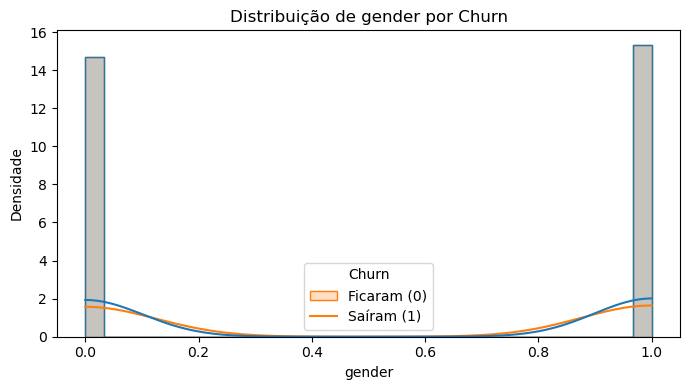

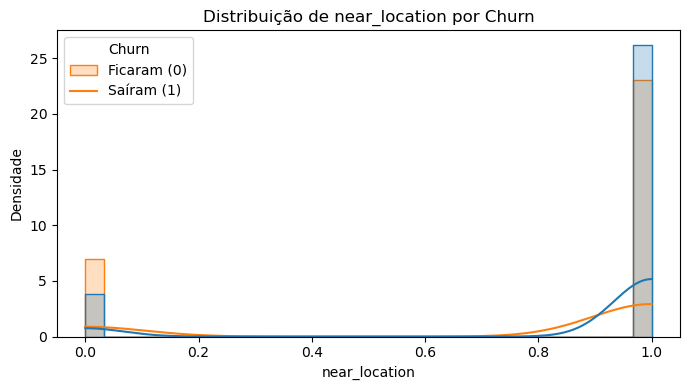

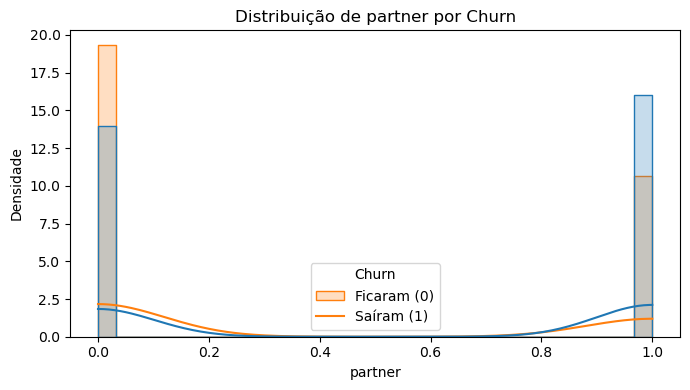

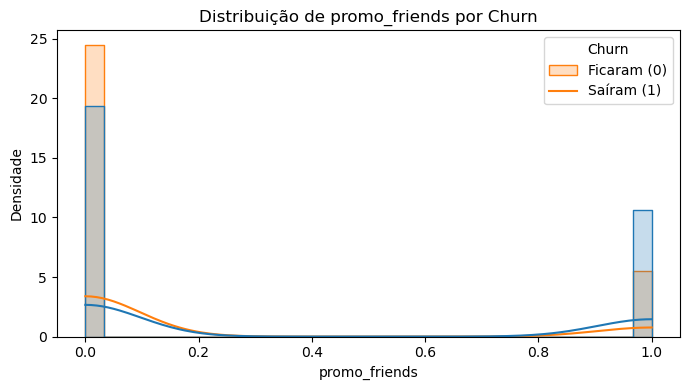

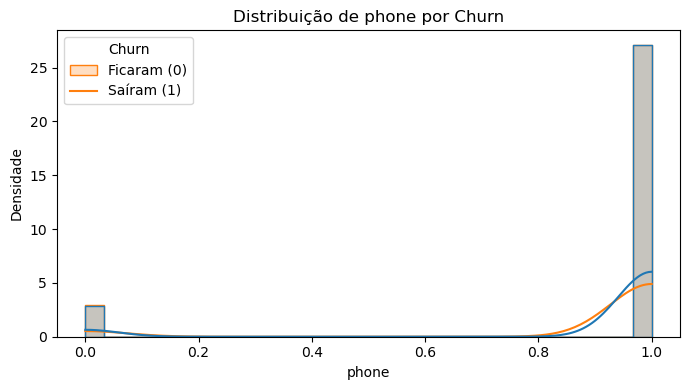

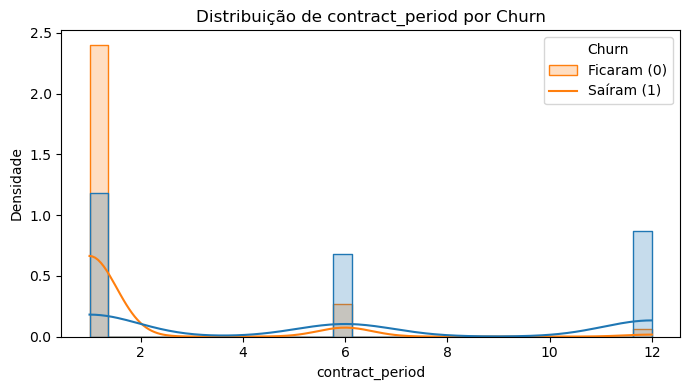

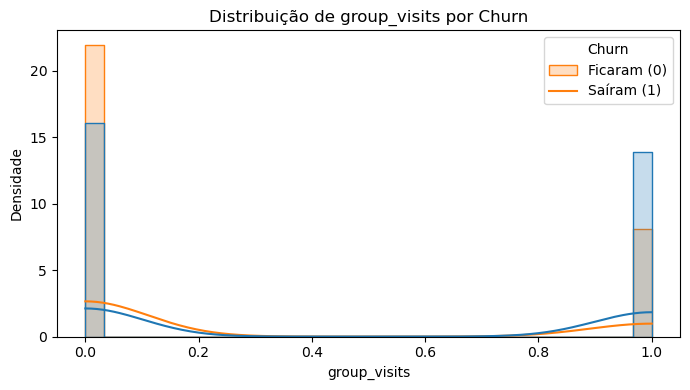

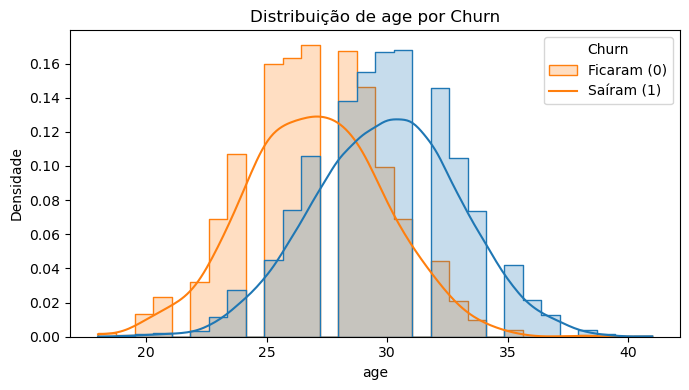

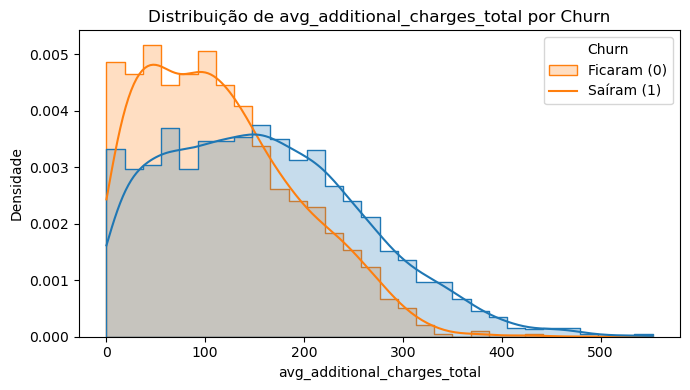

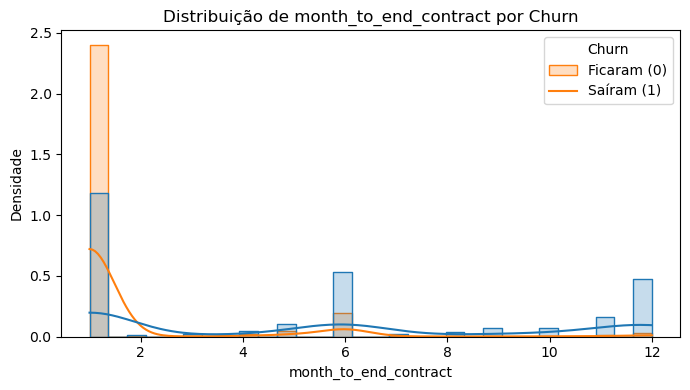

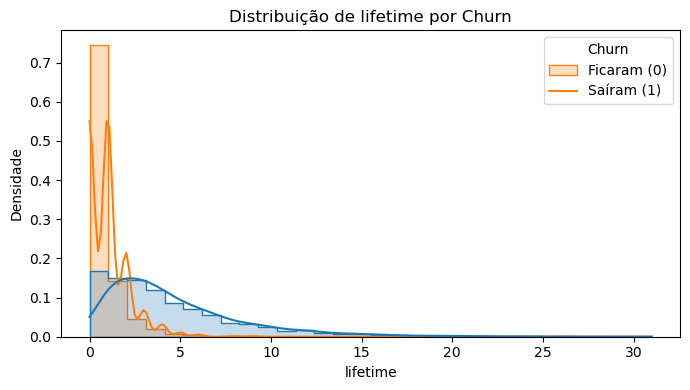

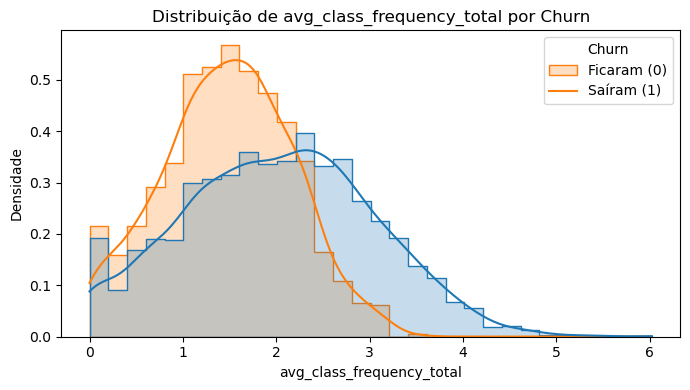

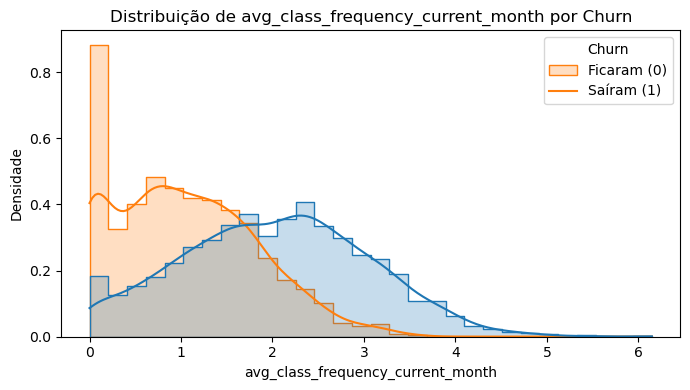

In [88]:
for feature in num_features:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=fitness, x=feature, hue='churn', kde=True, bins=30, element='step', stat='density', common_norm=False)
    plt.title(f'Distribuição de {feature} por Churn')
    plt.xlabel(feature)
    plt.ylabel('Densidade')
    plt.legend(title='Churn', labels=['Ficaram (0)', 'Saíram (1)'])
    plt.tight_layout()
    plt.show()

<span style="color: blue; font-family: Arial; font-size: 20px;">
Construa a matriz de correlação e a exiba.

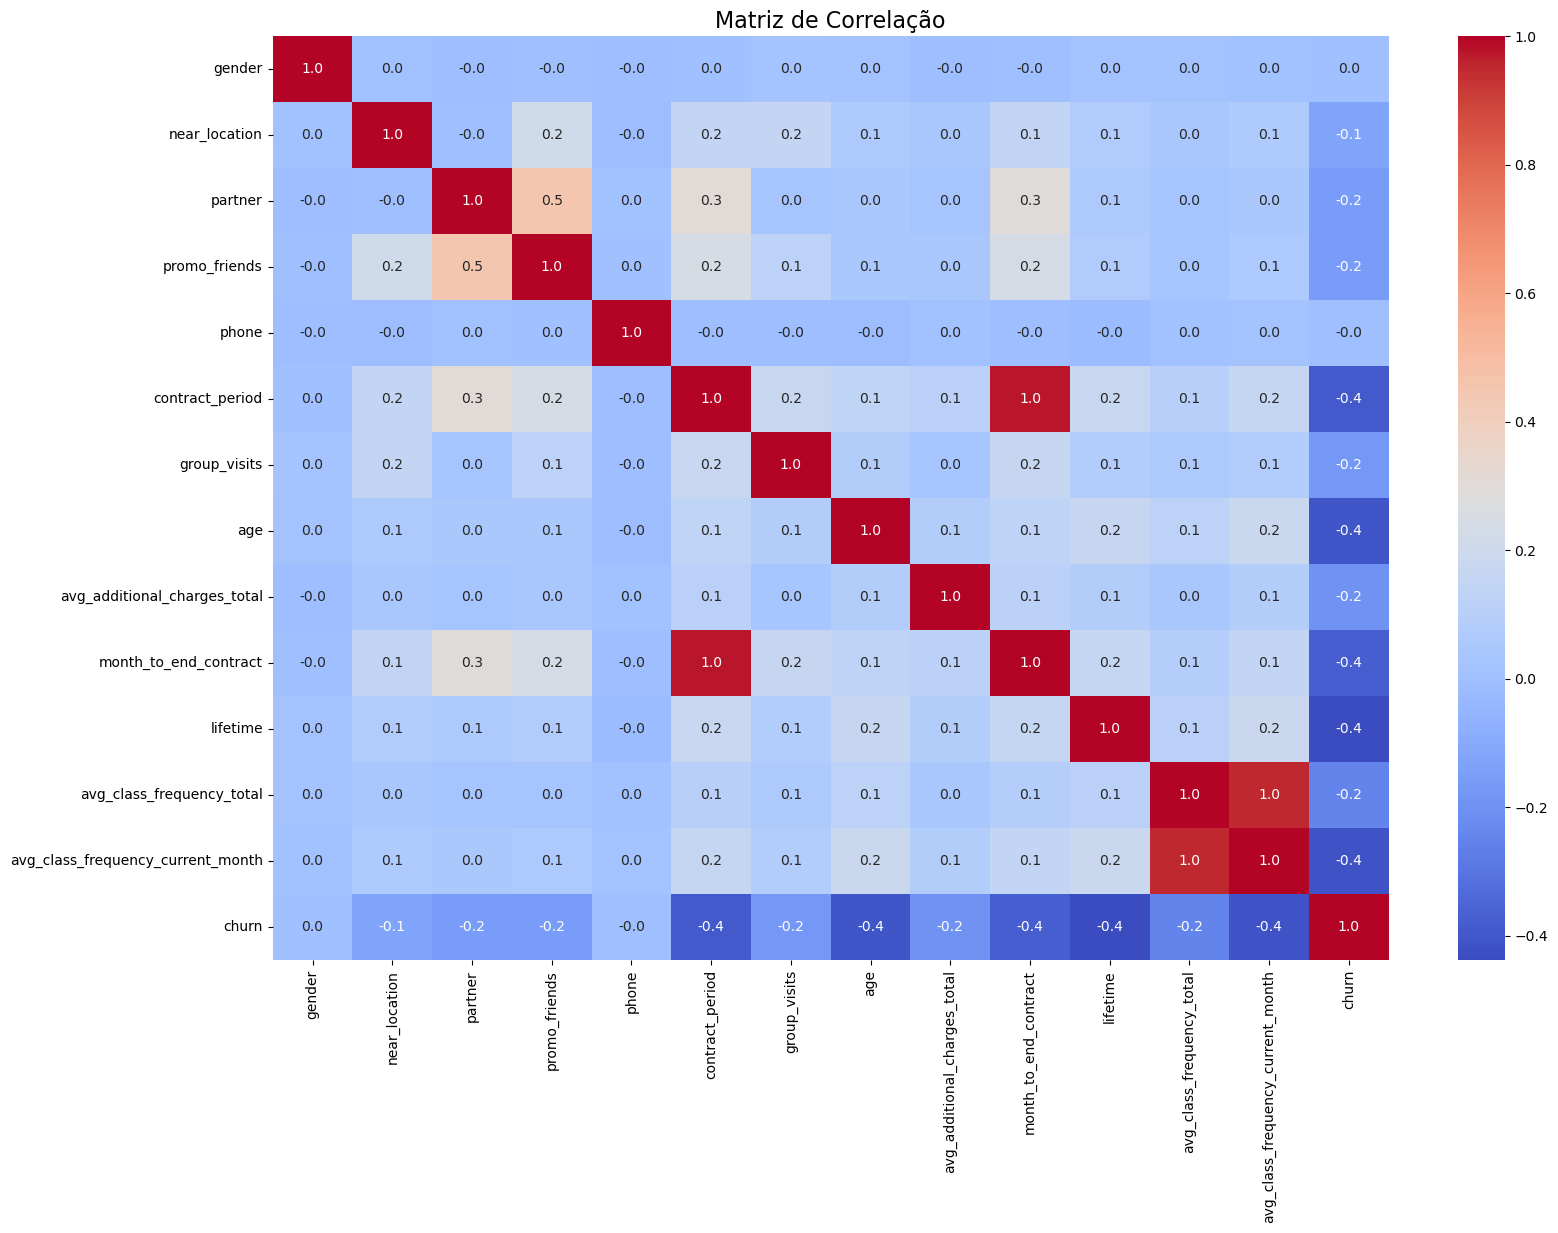

In [90]:
# Garantindo apenas colunas numéricas
num_df = fitness.select_dtypes(include=['number'])

# Calculando a matriz de correlação
cm = num_df.corr()

# Plotando um gráfico
plt.figure(figsize=(18,12))
sns.heatmap(cm, annot=True, fmt='.1f', cmap="coolwarm")
plt.title("Matriz de Correlação", fontsize=16)
plt.show()

## Construindo um modelo para predizer a rotatividade de clientes

<span style="color: blue; font-family: Arial; font-size: 20px;">

Dividindo os dados de treinamento e validação em dois conjuntos e treinando o modelo com dois métodos:

- regressão logística
- floresta aleatória

In [93]:
# Dividindo os dados em características (a matriz X) e a variável objetivo (y)
X = num_df.drop('churn', axis=1)
y = num_df['churn']

# Dividindo os dados sobre treinos e testes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Treinando o modelo
model_rfc = RandomForestClassifier(random_state=0)
model_rfc.fit(X_train, y_train)

# Fazendo as previsões
preds = model_rfc.predict(X_test)
probs = model_rfc.predict_proba(X_test)[:, 1]

# Calculando as métricas
print('Acurácia: {:.2f}'.format(accuracy_score(y_test, preds)))
print('Precisão: {:.2f}'.format(precision_score(y_test, preds)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, preds)))
print('F1: {:.2f}'.format(f1_score(y_test, preds)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probs)))

Acurácia: 0.92
Precisão: 0.84
Sensibilidade: 0.82
F1: 0.83
ROC_AUC: 0.97


In [94]:
# Definindo o algoritmo do modelo
model1 = LogisticRegression(max_iter=1000)

# Treinando o modelo
model1.fit(X_train, y_train)

# Fazendo previsões
predictions1 = model1.predict(X_test)
probabilities = model1.predict_proba(X_test)[:,1]

# Calculando as métricas
print('Acurácia: {:.2f}'.format(accuracy_score(y_test, predictions1)))
print('Precisão: {:.2f}'.format(precision_score(y_test, predictions1)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, predictions1)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions1)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

Acurácia: 0.92
Precisão: 0.86
Sensibilidade: 0.83
F1: 0.84
ROC_AUC: 0.97


<span style="color: black; font-family: Arial; font-size: 20px;">
Apesar dos dois modelos terem apresentado resultados bons e muito parecidos, o modelo da regressão logística apresentou um resultado melhor do que o da floresta aleatória, principalmente na precisão e na sensibilidade.

## Criando agrupamentos de clientes

<span style="color: blue; font-family: Arial; font-size: 20px;">
Padronizando os dados.

In [98]:
sc = StandardScaler()
x_sc = sc.fit_transform(num_df)

<span style="color: blue; font-family: Arial; font-size: 20px;">
Usando a função linkage() para construir a matriz das distâncias baseada na matriz de características padronizada.

In [100]:
linked = linkage(x_sc, method = 'ward')

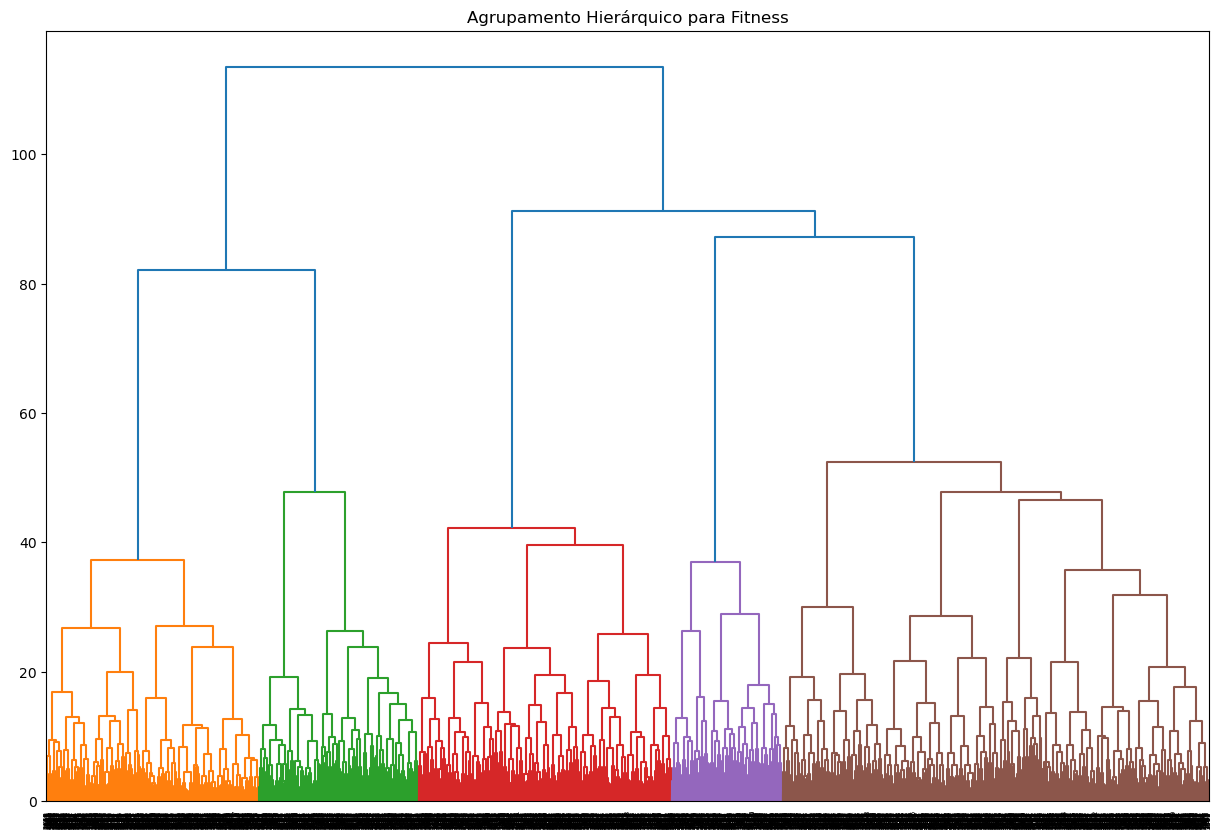

In [101]:
# Plotando dendrograma
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agrupamento Hierárquico para Fitness')
plt.show()

<span style="color: black; font-family: Arial; font-size: 20px;">
É possível destacar 5 agrupamentos, que correspondem às cinco cores diferentes do gráfico.

<span style="color: blue; font-family: Arial; font-size: 20px;">
Treinando o modelo de agrupamento com o algoritmo K-means e prevendo agrupamentos de clientes.

In [104]:
# Definindo o modelo k_means com 5 agrupamentos
km = KMeans(n_clusters=5)
# Prevendo os agrupamentos para observações (o algoritmo atribui a eles um número de 0 a 4)
labels = km.fit_predict(x_sc)

<span style="color: blue; font-family: Arial; font-size: 20px;">
Calculando a taxa de rotatividade para cada agrupamento.

In [106]:
num_df['cluster_km'] = labels
num_df.groupby(['cluster_km']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.515625,0.999178,0.323191,0.220395,1.000000,2.225329,0.455592,30.208882,161.058132,2.090461,4.900493,2.144427,2.147868,0.003289
1,0.497110,0.000000,0.462428,0.077071,0.996146,2.287091,0.215800,28.545279,136.048617,2.156069,2.832370,1.726813,1.550053,0.435453
2,0.505851,0.956796,0.788479,0.568857,1.000000,10.552655,0.538254,29.882988,159.559837,9.614761,4.612961,1.997608,1.991414,0.013501
3,0.509091,1.000000,0.333766,0.228571,1.000000,1.644156,0.285714,26.916883,115.058748,1.592208,1.070130,1.399798,1.006000,0.928571
4,0.526042,0.867188,0.471354,0.307292,0.000000,4.796875,0.429688,29.328125,144.408268,4.484375,3.960938,1.862114,1.731358,0.263021


<span style="color: black; font-family: Arial; font-size: 20px;">
No agrupamento 3, que teve a maior taxa de saída de clientes, pode-se verificar que os gastos adicionais na academia foram os mais baixos, com contratos mais curtos em relação aos outros agrupamentos. Além disso, apesar de representar o grupo com a menor faixa de idade, teve tambem uma taxa pequena de participações dos clientes nas sessões de grupo, o que explica muito a falta de engajamento desse agrupamento.


Os agrupamentos 0, 2 e 4 foram os que mais gastaram adicionalmente na academia e os que mais a visitam durante a semana. Apesar de terem a maior faixa etária, são também os que mais vão a academia desde quando começaram. Além disso, os agrupamentos 0, 2 e 4 são os que mais aproveitam as sessões em grupo, o que explica o bom engajamento desses agrupamentos.

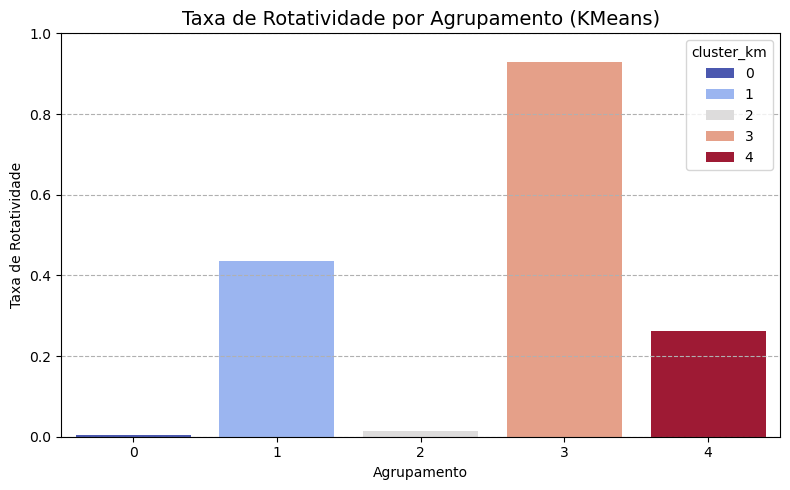

In [108]:
# Calculando a taxa de rotatividade por agrupamento
churn_rates = num_df.groupby('cluster_km')['churn'].mean().reset_index()

# Criando um gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=churn_rates, x='cluster_km', y='churn', hue='cluster_km', palette='coolwarm')
plt.title('Taxa de Rotatividade por Agrupamento (KMeans)', fontsize=14)
plt.xlabel('Agrupamento')
plt.ylabel('Taxa de Rotatividade')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

<span style="color: black; font-family: Arial; font-size: 20px;">
As taxas mostram que os agrupamentos 0 e 2 (principalmente o 0) tiveram clientes mais leais à academia. Porém, o agrupamento 3 teve quase uma taxa de 100% de clientes que saíram da academia, e nos agrupamentos 1 e 4 alguns clientes saíram, mostrando que esses três grupos são mais propensos a sair.

# Conclusões e Recomendações

<span style="color: black; font-family: Arial; font-size: 20px;">


A análise dos modelos de previsão de rotatividade e do comportamento dos clientes revelou que, embora tanto a regressão logística quanto a floresta aleatória apresentem bons resultados, a regressão logística se destacou em precisão e sensibilidade, tornando-a mais confiável para identificar clientes propensos a sair.

Os clientes foram segmentados em cinco agrupamentos distintos:

**Agrupamento 3**: apresentou a maior taxa de saída, caracterizado por gastos adicionais baixos, contratos curtos e baixa participação em sessões de grupo, apesar de ser o grupo com a menor faixa etária. Isso indica baixo engajamento e alto risco de rotatividade.

**Agrupamentos 0, 2 e 4**: clientes mais engajados, com maiores gastos adicionais, frequência alta e participação ativa em sessões de grupo. Esses grupos demonstram maior lealdade, especialmente o agrupamento 0.

**Agrupamentos 1 e 4**: apresentam risco moderado de saída, com alguns clientes deixando a academia.

Recomendações de Marketing:

1- Focar em retenção do **agrupamento 3**: desenvolver promoções personalizadas, programas de incentivo e comunicação direta, incentivando maior engajamento nas aulas em grupo e maior utilização dos serviços adicionais.

2- Reforçar programas de fidelidade para os **agrupamentos leais 0, 2 e 4**: premiar a frequência e participação, mantendo o engajamento alto e fortalecendo a relação com a academia.

3- Monitorar **agrupamentos de risco moderado 1 e 4**: identificar sinais de desengajamento precoce e atuar preventivamente com campanhas de marketing direcionadas, como ofertas exclusivas e notificações de incentivo.

4- Personalização das estratégias: ajustar mensagens, promoções e programas de engajamento de acordo com o perfil de cada agrupamento, maximizando a retenção e o lifetime value dos clientes.